# Exploring Cleaned Datasets

In this workbook we explore the hourly datasets collected with anomalous data replaced and missing data filled in. See the previous notebook for more information on the methods used here, data preperation and cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import math
from helper_functions import *
from datetime import date, timedelta
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

#Importing the datasets
current_folder = os.path.abspath('')

bitcoin_csv = os.path.join(current_folder, "data","bitcoin_hourly.csv")
ethereum_csv = os.path.join(current_folder, "data","ethereum_hourly.csv")
dogecoin_csv = os.path.join(current_folder, "data","dogecoin_hourly.csv")

bitcoin_df = pd.read_csv(bitcoin_csv)
ethereum_df = pd.read_csv(ethereum_csv)
dogecoin_df = pd.read_csv(dogecoin_csv)

bitcoin_df['highLowDif'] = bitcoin_df['highPriceUsd'] - bitcoin_df['lowPriceUsd']
ethereum_df['highLowDif'] = ethereum_df['highPriceUsd'] - ethereum_df['lowPriceUsd']
dogecoin_df['highLowDif'] = dogecoin_df['highPriceUsd'] - dogecoin_df['lowPriceUsd']

# removing features we do not wish to plot, or that will not be used in predictions
bitcoin_df = bitcoin_df.drop(columns=['openPriceUsd', 'highPriceUsd', 'lowPriceUsd', 'marketcap'])
ethereum_df = ethereum_df.drop(columns=['openPriceUsd', 'highPriceUsd', 'lowPriceUsd', 'marketcap'])
dogecoin_df = dogecoin_df.drop(columns=['openPriceUsd', 'highPriceUsd', 'lowPriceUsd', 'marketcap'])

# Creating lists of variable names for each dataset
bitcoin_column_names = list(bitcoin_df.columns.values.tolist())
ethereum_column_names = list(ethereum_df.columns.values.tolist())
dogecoin_column_names = list(dogecoin_df.columns.values.tolist())

time_column = 'datetime'
# removing the time column from column names (so it is not plotted by itself)
bitcoin_column_names.remove(time_column)
ethereum_column_names.remove(time_column)
dogecoin_column_names.remove(time_column)

# Setting the plot titles for each cryptocurrency (optional)
titles = ['tweet count', 'polarity without zeros', 'subjectivity without zeros', 'polarity with zeros', 'subjectivity with zeros', 'close price', 'volume', 'difference high low']

bitcoin_titles = []
ethereum_titles = []
dogecoin_titles = []

for title in titles:
    bitcoin_title = 'Bitcoin ' + title
    ethereum_title = 'Ethereum ' + title
    dogecoin_title = 'Dogecoin ' + title
    bitcoin_titles.append(bitcoin_title)
    ethereum_titles.append(ethereum_title)
    dogecoin_titles.append(dogecoin_title)

# removing UTC from dates to make them easier to print below plots
bitcoin_df[time_column] = pd.to_datetime(bitcoin_df[time_column], errors='coerce', utc=False)
ethereum_df[time_column] = pd.to_datetime(ethereum_df[time_column], errors='coerce', utc=False)
dogecoin_df[time_column] = pd.to_datetime(dogecoin_df[time_column], errors='coerce', utc=False)

# Filtering dates to official 100 day collection period
start_point = bitcoin_df['datetime'][0]
end_point = start_point + timedelta(100)
filter_dates = bitcoin_df['datetime'] >= pd.to_datetime(start_point)
bitcoin_df = bitcoin_df[filter_dates]
ethereum_df = ethereum_df[filter_dates]
dogecoin_df = dogecoin_df[filter_dates]
filter_dates = bitcoin_df['datetime'] < pd.to_datetime(end_point)
bitcoin_df = bitcoin_df[filter_dates]
ethereum_df = ethereum_df[filter_dates]
dogecoin_df = dogecoin_df[filter_dates]


# converting to strings format 'DD-MM-YYYY hr:00'
bitcoin_df[time_column] = bitcoin_df[time_column].dt.strftime('%d-%m-%Y %H:00')
ethereum_df[time_column] = ethereum_df[time_column].dt.strftime('%d-%m-%Y %H:00')
dogecoin_df[time_column] = dogecoin_df[time_column].dt.strftime('%d-%m-%Y %H:00')

## Exploring Bitcoin Data

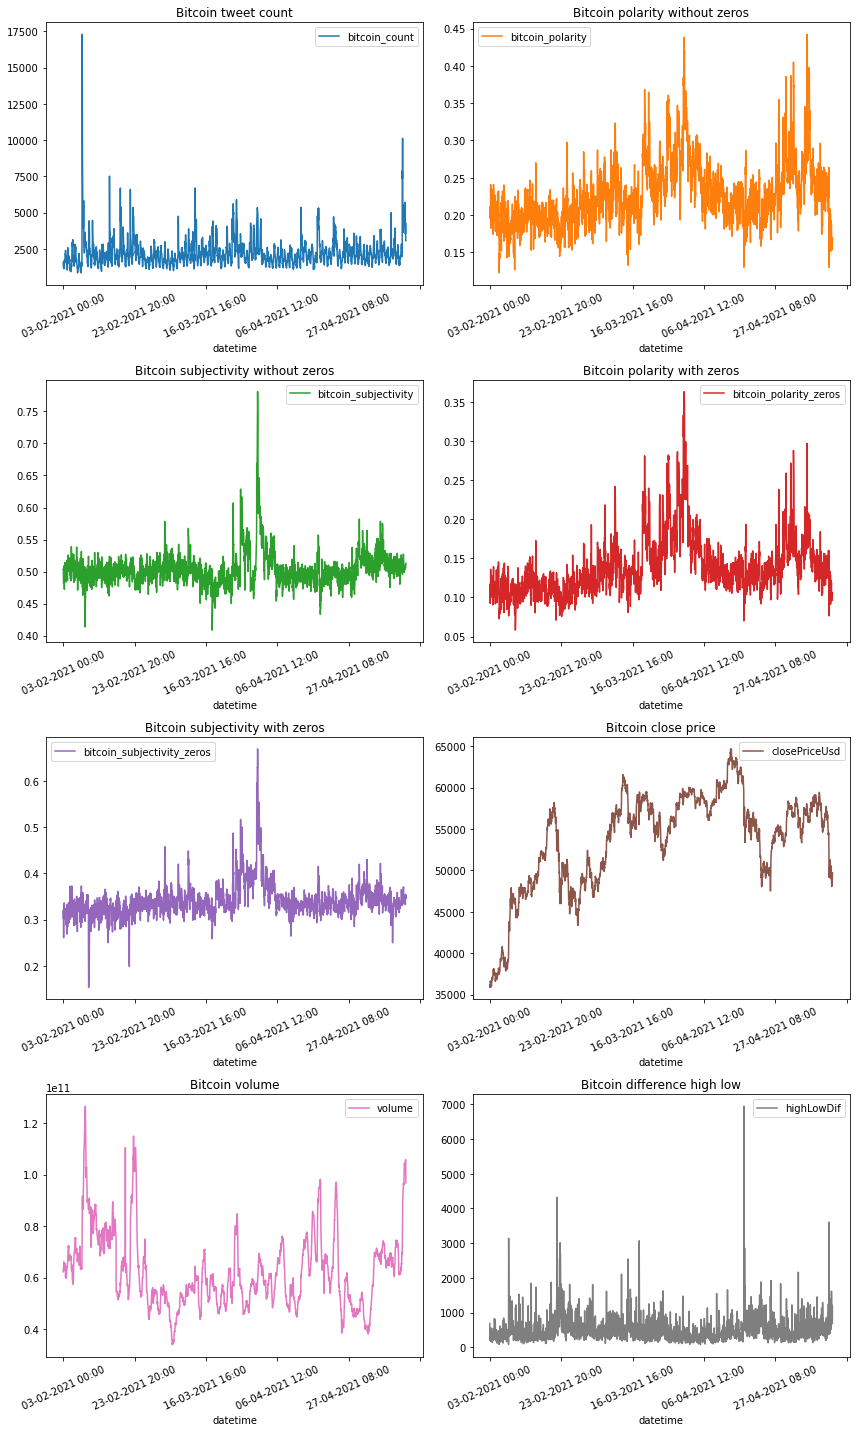

In [2]:
plot_timeseries_features(bitcoin_df, bitcoin_column_names, time_column, bitcoin_titles)

Without the anomalous data point the bitcoin trade volume plot looks much better.

With some generous interpretation the rise and falls in twitter polarity ratings seem to proceed price rises, though this may be coincidence.

### Feature heatmap

By plotting the correlation of features against each other we can get some indication of features that may be useful to include when trying to make price predictions.

We are interested mostly in features correlated with 'closePriceUsd'.

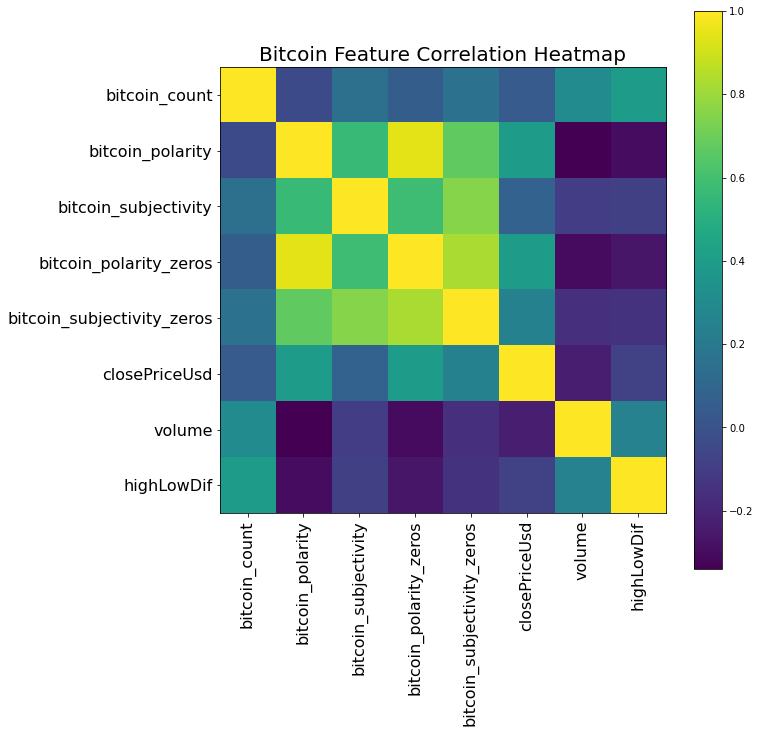

In [3]:
plot_heatmap(bitcoin_df, "Bitcoin", bitcoin_column_names)

- Mild correlation between tweet volume, trade volume and the difference between high and low values
- Correlation between tweet volume and trade volume could come down to the daily periodicty of trading (peak hours for trading may be similar to twitter peak)
- looking at close price, there seems to be stronger correlation with polarity than tweet volume (this may be due to the daily periodicity of volume)
- The polarity and subjectivity with zeros correlation values are slightly higher  with close price (than those without zeros)
- Unexpectedly trade volume and volatility (highlowDif) don't seem to correlate very much with the close price. In fact there is a negative correlation between trade volume and close price.

## Inspecting Ethereum Data:

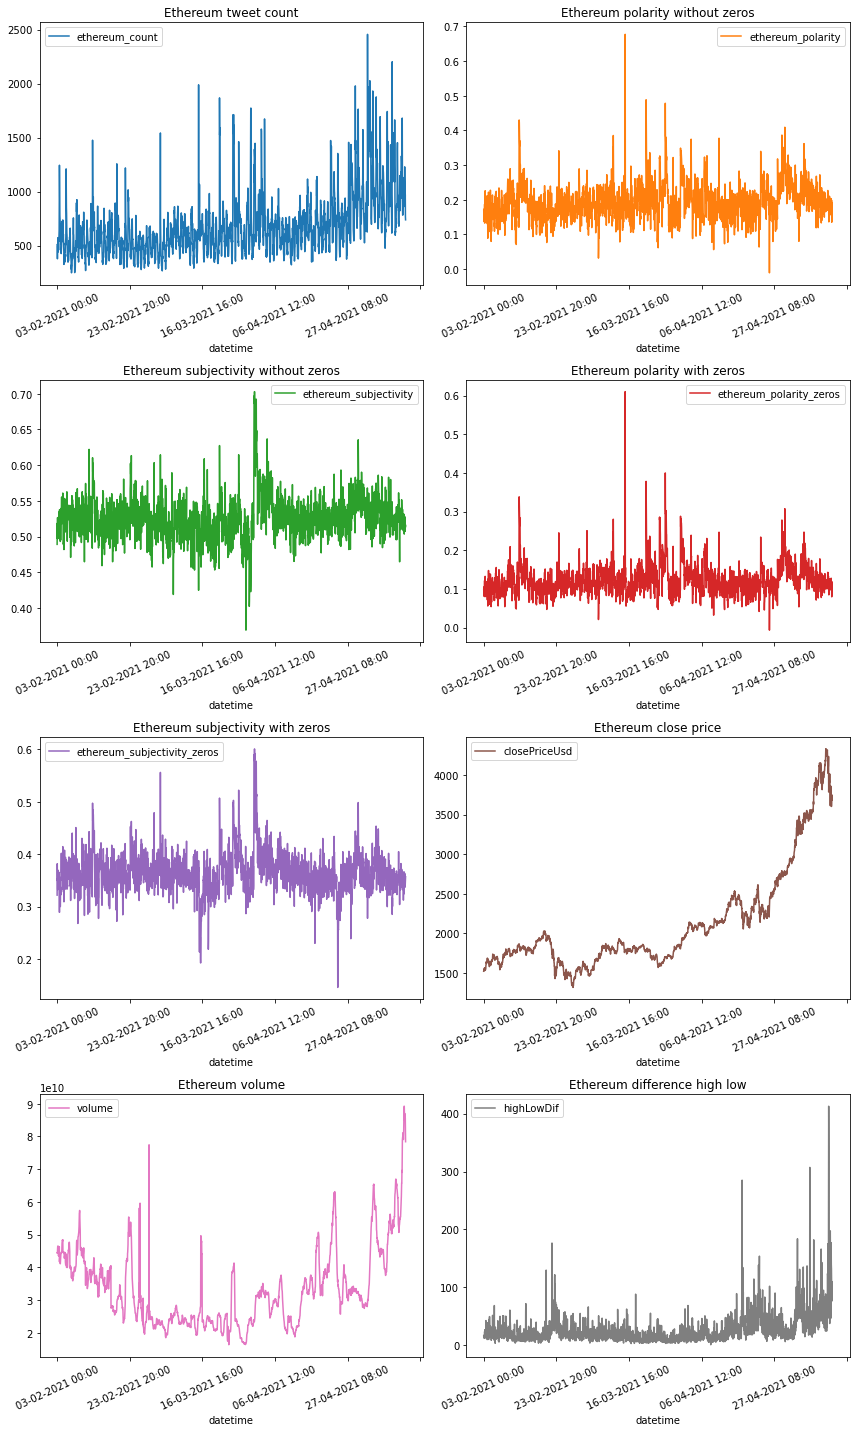

In [4]:
plot_timeseries_features(ethereum_df, ethereum_column_names, time_column, ethereum_titles)

### Feature heatmap

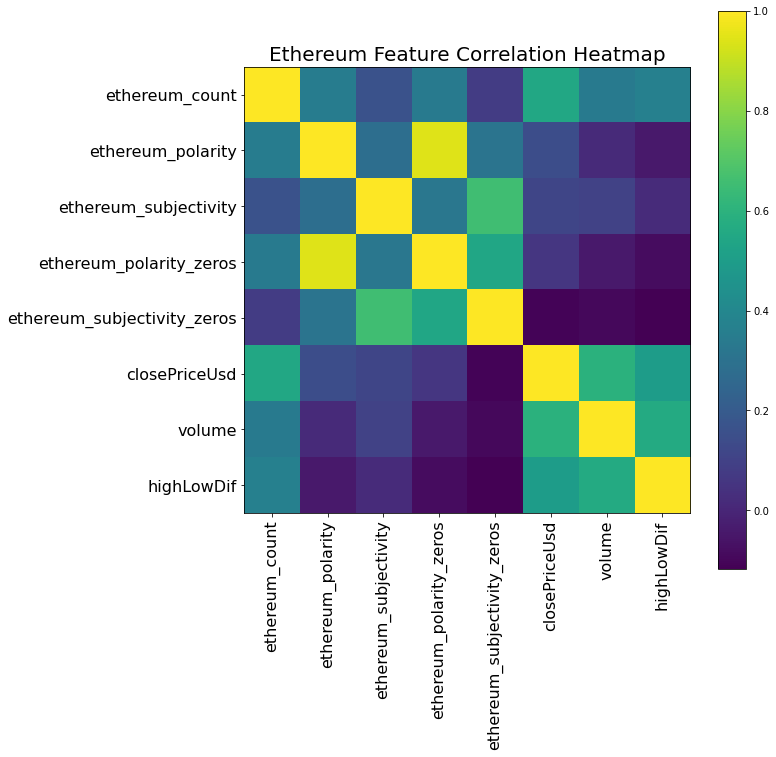

In [5]:
plot_heatmap(ethereum_df, "Ethereum", ethereum_column_names)

- Unlike bitcoin tweet volume seems more correlated with close price than measures of sentiment (polarity and subjectivity)
- Also unlike bitcoin trade volume and volatility do seem to have a fairly strong correlation with close price
- There does still seem to be a mild correlation between polarity and close price, though lower than with bitcoin.
- Interestingly the sentiment scores without zeros seem to be more correlated than those with zeros (unlike bitcoin). This may be because the tweet volume for ethereum is relatively low and quite a large proportion of tweets are often spam. removing zero sentiment scores also filters out many spam messages.

## Inspecting Dogecoin Data

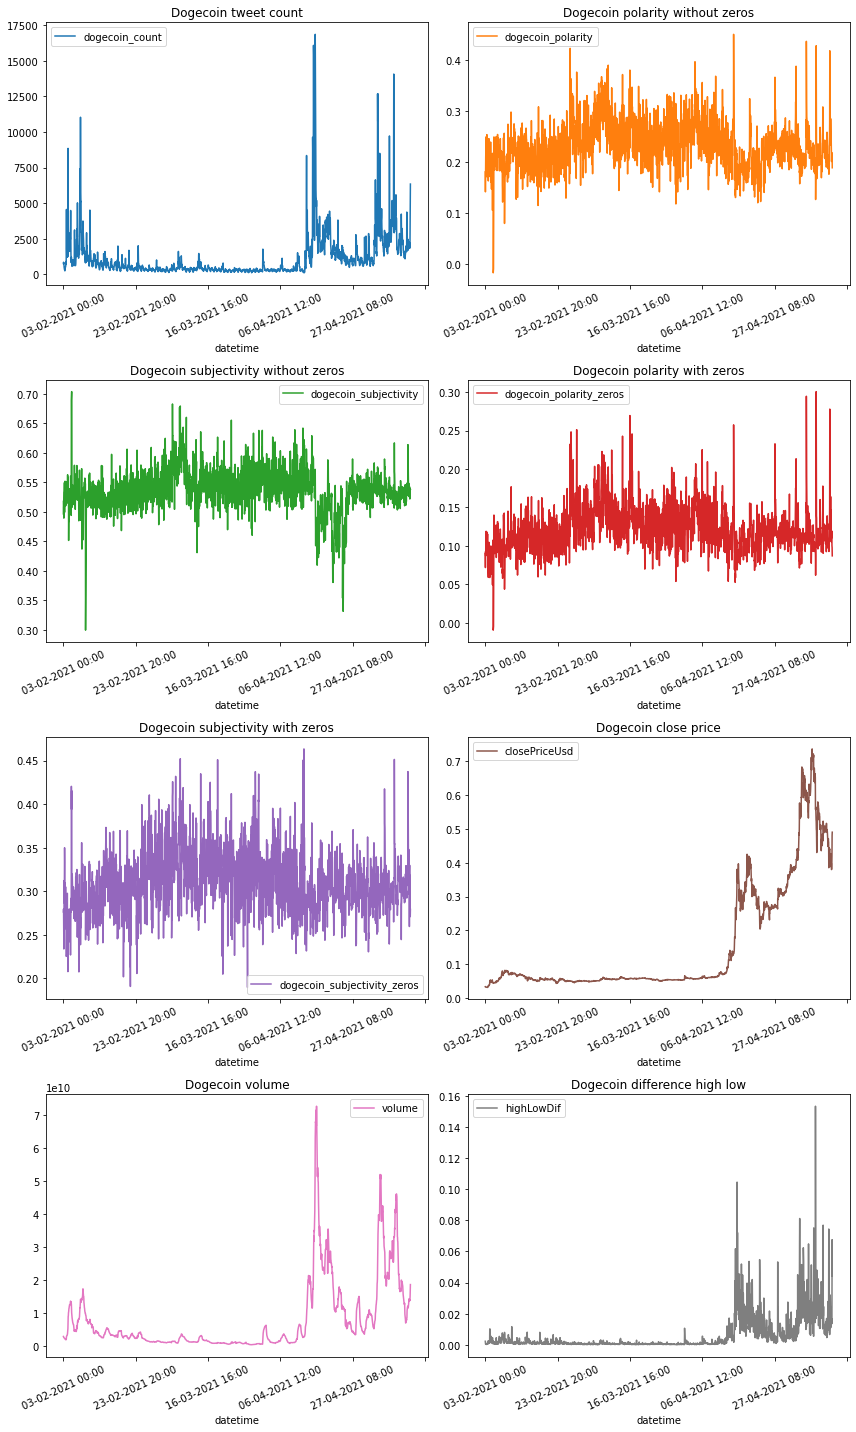

In [6]:
plot_timeseries_features(dogecoin_df, dogecoin_column_names, time_column, dogecoin_titles)

### Feature heatmap

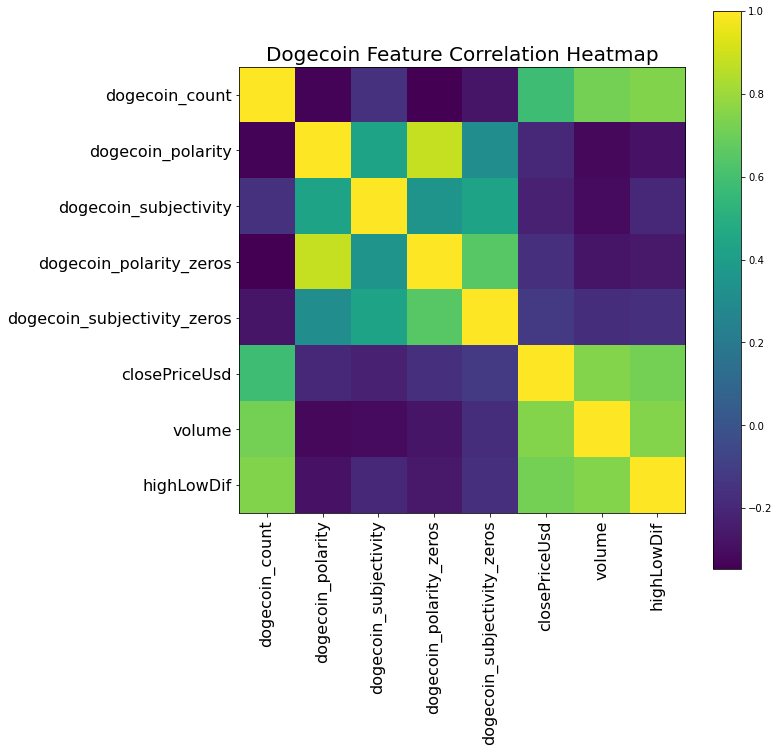

In [7]:
plot_heatmap(dogecoin_df, "Dogecoin", dogecoin_column_names)

- There is a much stronger correlation between tweet volume and close price
- Polarity and subjectivity seem to have lower correlations than ethereum or bitcoin
- interestingly like bitcoin the sentiment scores with zero values are more correlated than those without
- There are even stronger correlations between trade volume, voltility and close price compared to ethereum. 

## Conclusions

I was not expecting such a difference between the cryptocurrencies. It is likely that models for each coin would benefit from different parameters being included:

- Bitcoin will likely benefit from sentiment scores with zero values and possibly very mildly from tweet count.
- Ethereum will likely benefit from tweet count, trade volume and volatility (or high and low values seperately). It may also benefit mildly from sentiment scores without zero values
- Dogecoin will likely benefit a lot from tweet volume, trade volume and volatility, it may also benefit a small amount from sentiment scores with zero values included.